# 전처리

In [2]:
import os
import json
import pandas as pd

json_folder = 'Sample/02.라벨링데이터'
audio_folder = 'Sample/01.원천데이터'
rows = []

for filename in os.listdir(json_folder):
    if filename.endswith('.json'):
        with open(os.path.join(json_folder, filename), 'r', encoding='utf-8') as f:
            try:
                data = json.load(f)
                wav_id = data.get('File', {}).get('FileName', '') + '.wav'
                conversations = data.get('Conversation', [])

                for conv in conversations:
                    try:
                        # 쉼표 제거 후 float 변환
                        start_time = float(conv.get('StartTime', '0').replace(',', ''))
                        end_time = float(conv.get('EndTime', '0').replace(',', ''))
                        emotion = conv.get('SpeakerEmotionCategory', 'unknown')

                        rows.append({
                            'wav_id': wav_id,
                            'start_time': start_time,
                            'end_time': end_time,
                            'Text': conv.get('Text', '').strip(),
                            'emotion': emotion
                        })
                    except ValueError as e:
                        print(f"⚠️ 대화 오류 in {filename}: {e}")
                        continue

            except Exception as e:
                print(f"⚠️ 파일 오류 in {filename}: {e}")
                continue
                
# ✅ DataFrame 생성
df = pd.DataFrame(rows)

# ✅ 감정 레이블 숫자 변환
label_map = {'긍정': 0, '중립': 1, '부정': 1}
df['emotion'] = df['emotion'].map(label_map)

print(df.head(5))

                                              wav_id  start_time  end_time  \
0  2_1397G1A4_1398G2A6_T1_2D06T0221C000476_005157...        5.70      6.98   
1  2_1397G1A4_1398G2A6_T1_2D06T0221C000476_005157...        6.05      6.83   
2  2_1397G1A4_1398G2A6_T1_2D06T0221C000476_005157...        6.95      9.98   
3  2_1397G1A4_1398G2A6_T1_2D06T0221C000476_005157...        7.50      8.73   
4  2_1397G1A4_1398G2A6_T1_2D06T0221C000476_005157...       10.10     12.23   

         Text  emotion  
0           어        1  
1           어        1  
2  제가 출장을 가면은        1  
3          제가        1  
4         꼭 그        1  


In [3]:
# 제거 대상 리스트
remove_texts = ['어', '음', '그', '어.', '어 어']

# 제거한 새로운 DataFrame 생성
df_sampled = df[~df['Text'].isin(remove_texts)]

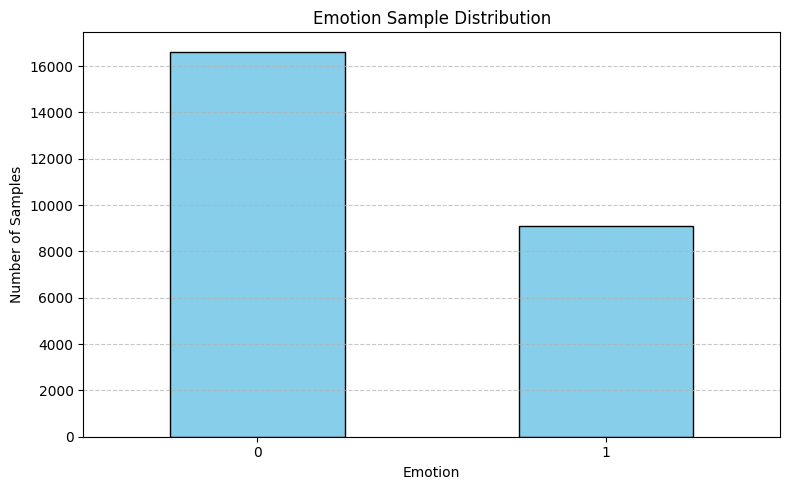

In [4]:
import matplotlib.pyplot as plt

# 감정별 샘플 수 세기
emotion_counts = df_sampled['emotion'].value_counts()

# 바 플롯 시각화
plt.figure(figsize=(8, 5))
emotion_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Emotion Sample Distribution')
plt.xlabel('Emotion')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [5]:
# 1. 긍정 감정만 따로 선택
df_positive = df_sampled[df_sampled['emotion'] == 0]

# 2. 긍정 감정 중 1/2만 랜덤 추출
df_positive_reduced = df_positive.sample(frac=1/2, random_state=42)

# 3. 긍정 이외(중립 + 부정) 데이터 선택
df_others = df_sampled[df_sampled['emotion'] == 1]

# 4. 다시 합치기
df_sampled = pd.concat([df_positive_reduced, df_others]).reset_index(drop=True)
df_sampled = df_sampled.sample(frac=0.3, random_state=42).reset_index(drop=True)

# ✅ 확인
print(df_sampled['emotion'].value_counts())

emotion
1    2738
0    2484
Name: count, dtype: int64


In [6]:
import librosa
import numpy as np
from tqdm import tqdm  # 진행률 확인용
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical

In [8]:
def extract_features(y, sr):
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)

    spec_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spec_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    spec_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
    spec_flatness = np.mean(librosa.feature.spectral_flatness(y=y))
    spec_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))

    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)

    harm = librosa.effects.harmonic(y)
    inh = np.mean(np.abs(y - harm))
    tristimulus = np.mean(librosa.feature.rms(y=harm))
    harm_energy = np.mean(librosa.feature.rms(y=harm))
    noise_energy = np.mean(librosa.feature.rms(y=y - harm))
    noiseness = noise_energy / (harm_energy + 1e-6)

    return np.hstack([
        mfccs,
        [spec_centroid, spec_bandwidth, spec_contrast, spec_flatness, spec_rolloff],
        chroma,
        [inh, tristimulus, harm_energy, noise_energy, noiseness]
    ])

In [9]:
X = []
y = []

# 레이블 인코더 준비
le = LabelEncoder()
df_sampled['emotion_label'] = le.fit_transform(df_sampled['emotion'])

# tqdm을 활용한 Feature 추출
for idx, row in tqdm(df_sampled.iterrows(), total=len(df_sampled)):
#for idx, row in tqdm(df_sampled.head(10).iterrows(), total=10):
    file_path = os.path.join(audio_folder, row['wav_id'])

    if not os.path.exists(file_path):
        continue

    try:
        y_audio, sr = librosa.load(file_path, sr=24000, offset=row['start_time'], duration=row['end_time'] - row['start_time'])

        if len(y_audio) == 0:
#            print(f"⚠️ 비어 있는 오디오 구간: {row['wav_id']}, start={row['start_time']}, end={row['end_time']}")
            continue

        features = extract_features(y_audio, sr)
        X.append(features)
        y.append(row['emotion'])

    except Exception as e:
        print(f"⚠️ Feature 추출 실패: {row['wav_id']} / {e}")
        continue


 11%|████▍                                   | 579/5222 [01:40<08:32,  9.07it/s]/var/folders/tq/hww09xy10c5_nzf2crt5rqxh0000gn/T/ipykernel_16016/3696151615.py:17: UserWarning: PySoundFile failed. Trying audioread instead.
  y_audio, sr = librosa.load(file_path, sr=24000, offset=row['start_time'], duration=row['end_time'] - row['start_time'])
/Users/sunof6/.pyenv/versions/tf_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 11%|████▍                                   | 581/5222 [01:40<11:31,  6.71it/s]

⚠️ 비어 있는 오디오 구간: 2_1377G2A2_1376G2A2_T1_2D09T0417C000394_004992.wav, start=1018.84, end=1019.15


 11%|████▌                                   | 595/5222 [01:43<15:35,  4.94it/s]

⚠️ 비어 있는 오디오 구간: 2_2593G2A3_2481G2A3_T2_2D01T0002C000175_010980.wav, start=347.96, end=351.67


 22%|████████▍                              | 1132/5222 [03:03<13:33,  5.03it/s]

⚠️ 비어 있는 오디오 구간: 2_1377G2A2_1376G2A2_T1_2D09T0416C000442_004984.wav, start=1032.9, end=1036.06


 32%|████████████▋                          | 1696/5222 [04:18<05:51, 10.03it/s]

⚠️ 비어 있는 오디오 구간: 2_2593G2A3_2481G2A3_T2_2D01T0002C000175_010980.wav, start=337.7, end=340.88


 42%|████████████████▌                      | 2217/5222 [05:13<05:40,  8.83it/s]

⚠️ 비어 있는 오디오 구간: 2_1377G2A2_1376G2A2_T1_2D09T0416C000442_004984.wav, start=1027.47, end=1029.15


 50%|███████████████████▍                   | 2607/5222 [05:53<03:44, 11.64it/s]

⚠️ 비어 있는 오디오 구간: 2_1377G2A2_1376G2A2_T1_2D09T0375C000414_004986.wav, start=1034.41, end=1035.55


 69%|██████████████████████████▉            | 3609/5222 [07:42<03:04,  8.77it/s]

⚠️ 비어 있는 오디오 구간: 2_2593G2A3_2481G2A3_T2_2D01T0002C000175_010980.wav, start=444.36, end=447.03


 72%|████████████████████████████           | 3760/5222 [07:59<02:32,  9.61it/s]

⚠️ 비어 있는 오디오 구간: 2_1377G2A2_1376G2A2_T1_2D09T0417C000394_004992.wav, start=1031.44, end=1033.49


 75%|█████████████████████████████▍         | 3939/5222 [08:19<02:20,  9.11it/s]

⚠️ 비어 있는 오디오 구간: 2_1382G2A5_1396G2A5_T1_2D06T0233C000134_005168.wav, start=509.1, end=510.38


 77%|█████████████████████████████▊         | 3997/5222 [08:25<02:19,  8.76it/s]

⚠️ 비어 있는 오디오 구간: 2_2593G2A3_2481G2A3_T2_2D01T0002C000175_010980.wav, start=366.2, end=366.46


 97%|█████████████████████████████████████▊ | 5071/5222 [10:16<00:19,  7.71it/s]

⚠️ 비어 있는 오디오 구간: 2_1377G2A2_1376G2A2_T1_2D09T0375C000414_004986.wav, start=1001.86, end=1005.03


100%|███████████████████████████████████████| 5222/5222 [10:32<00:00,  8.26it/s]


# 클래스 가중치 구하기
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 정수 라벨 기반으로 가중치 계산
y_int = y_encoded  # [0, 2, 1, ...]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_int), y=y_int)

# 딕셔너리 형태로 변환
class_weight_dict = dict(enumerate(class_weights))
print("클래스 가중치:", class_weight_dict)

from tensorflow.keras.layers import Input
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


X = np.array(X)
y = np.array(y)
X2 = X.reshape((X.shape[0], 1, X.shape[1]))

# 문자열 → 정수 인코딩
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # ['긍정', '긍정', '중립'] → [0, 0, 1, ...]

# 정수 → one-hot 인코딩
y_cat = to_categorical(y_encoded)

X2_train, X2_test, y_train, y_test = train_test_split(X2, y_cat, random_state=42)

# LSTM 레이어 2개, Dense 레이어 2개
model = Sequential([
    Input(shape=(1, 35)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(128, activation='relu'),
    Dense(2, activation='sigmoid')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

model.fit(X2_train, y_train, epochs=10, batch_size=32, validation_data=(X2_test, y_test))


In [12]:
from tensorflow.keras.layers import Input, LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import SGD, RMSprop, AdamW

X = np.array(X) 
X2 = X.reshape(-1, 1, 35)

# 레이블을 정수 (0 또는 1)로 유지
le = LabelEncoder()
y_binary = le.fit_transform(y)  # 이진 레이블

# train/test 분리
X2_train, X2_test, y_train, y_test = train_test_split(X2, y_binary, random_state=42)

# 모델 정의
model = Sequential([
    Input(shape=(1, 35)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # ✔️ 이진 분류
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

model.fit(X2_train, y_train, epochs=10, batch_size=32, validation_data=(X2_test, y_test))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,369 (165.50 KB)

 Trainable params: 42,369 (165.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5556 - loss: 0.6851 - val_accuracy: 0.5725 - val_loss: 0.6783
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5602 - loss: 0.6841 - val_accuracy: 0.6316 - val_loss: 0.6651
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5806 - loss: 0.6751 - val_accuracy: 0.6385 - val_loss: 0.6637
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5733 - loss: 0.6814 - val_accuracy: 0.6385 - val_loss: 0.6687
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6320 - loss: 0.6584 - val_accuracy: 0.6416 - val_loss: 0.6475
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6269 - loss: 0.6538 - val_accuracy: 0.5510 - val_loss: 0.6808
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6138 - loss: 0.6610 - val_accuracy: 0.5579 - val_loss: 0.6746
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5200 - loss: 0.6893 - val_accuracy: 0.

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step


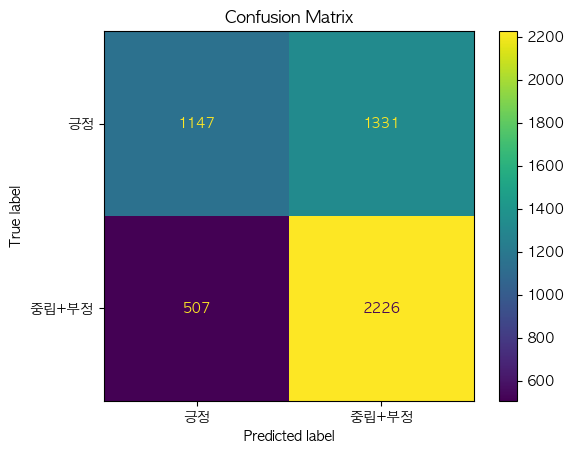

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.font_manager as fm

# macOS 전용: AppleGothic 사용
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# ✅ 예측 확률 → 클래스
X_array = np.array(X).reshape(-1, 1, 35)
y_pred_prob = model.predict(X_array)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# ✅ 정답
y_true = np.array(y_binary)

# ✅ 혼동 행렬
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['긍정', '중립+부정'])
disp.plot(cmap='viridis')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [46]:
import librosa
import numpy as np

# ✅ 1. 음성 로딩
y_audio, sr = librosa.load("영천시.m4a", sr=24000)

# ✅ 2. 피처 추출 (기존 학습에서 쓰던 extract_features 함수 사용)
features = extract_features(y_audio, sr)  # shape: (35,)

# ✅ 3. 모델 입력 형태로 변형 → (1, 1, 35)
X_input = np.array(features).reshape(1, 1, 35)

# ✅ 4. 예측
y_prob = model.predict(X_input)  # sigmoid 확률 값
y_pred = (y_prob > 0.5).astype(int)[0][0]  # 이진 분류

# ✅ 5. 결과 해석
label_map = {0: '긍정', 1: '중립+부정'}
print(f"예측 감정: {label_map[y_pred]} (확률: {y_prob[0][0]:.4f})")

/var/folders/tq/hww09xy10c5_nzf2crt5rqxh0000gn/T/ipykernel_16016/3068284352.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y_audio, sr = librosa.load("영천시.m4a", sr=24000)
/Users/sunof6/.pyenv/versions/tf_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
예측 감정: 긍정 (확률: 0.3027)
